# Running Analysis — Track vs Coastal Path

The goal is to answer this question:

> **Why is my average pace consistently better on the track than on the coastal path, even at a similar heart rate?**


## Surfaces Compared
- **Track**: 200m track, not very flat surface  
- **Coastal Road**: path along the seaside, not very flat, no slopes, not on sand  


## Hypotheses

1. **Heart rate vs pace** → For the same heart rate (effort), is pace faster on track than on coastal path?  
2. **Session type comparison** → Does it depend on session type?  
3. **Elevation gain** → Does terrain profile explain the difference?  
4. **Time evolution** → Did progression/regression influence the results?  
5. **Distance effect** → Do I run longer sessions on the coastal path?  


## Dataset

- **File**: `run2025.csv`  
- **Features**:  
  - Date  
  - Distance  
  - Type  
  - Time  
  - Location  
  - Average pace  
  - Average heart rate  
  - Elevation gain  
  - Average power  
  - Max altitude  


In [2]:
import pandas as pd
import datetime as dt
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns

runLoua_path =  r"C:\Users\HP\Desktop\ProjetExcel\run2025.csv"
#Load the dataset
runLoua_data = pd.read_csv(runLoua_path, sep=';', encoding='latin1')
#preview of the 5 first rows
runLoua_data.tail()

,Date,Distance,Type,Time,Location,Avg Pace/km,Avg HR,Avg power,Elev gain,Max Alt
32,09-Aug,11.0,Threshold run,01:05:37,Track,5'58,182,173,196,15
33,11-Aug,5.0,Threshold run,00:30:49,Coastal path,6'10,171,167,2,19
34,12-Aug,6.6,Intervals,00:40:02,Coastal path,6'04,175,169,4,24
35,16-Aug,6.5,Threshold run,00:40:16,Coastal path,6'11,181,166,5,19
36,17-Aug,6.0,Tempo,00:37:49,Coastal path,6'18,171,162,3,17


In the dataset, we can see maximum altitude values from 10 to 30 meters for the coastal path, but that’s just the slope I run down at the beginning. After that, it’s a flat road, and I stop the run before going back up the slope.

In [3]:
#Data preparation

#Date-> Datetime format
runLoua_data["Date"] = pd.to_datetime(runLoua_data["Date"], format="%d-%b")

runLoua_data["Date"] = runLoua_data["Date"].apply(lambda d: d.replace(year=2025))

#Time -> secondes

def to_seconds(t):
    
    parts = t.split(':')
    parts = [int(p) for p in parts]
    
    if len(parts)==3:
        h, m, s = parts
    elif len(parts)==2:
        h, m, s = 0, parts[0], parts[1]
    else:
        return None
    return h*3600 + m*60 + s

runLoua_data["Time_sec"] = runLoua_data["Time"].apply(to_seconds)


#Avg pace ex: 6'12 -> secondes per km

def to_secondsperkm(pace): #6'18
    parts = pace.split("'") #['6','18']
    
    parts = [int(p) for p in parts] #[6, 18]
    
    m, s = parts
    
    return m*60 + s

runLoua_data["Pace_sec/km"] = runLoua_data["Avg Pace/km"].apply(to_secondsperkm)

runLoua_data.head()


,Date,Distance,Type,Time,Location,Avg Pace/km,Avg HR,Avg power,Elev gain,Max Alt,Time_sec,Pace_sec/km
0,2025-03-30,4.00,Threshold run,00:26:10,Coastal path,6'32,180,159,0,19,1570,392
1,2025-03-30,3.01,Threshold run,00:17:44,Coastal path,5'54,195,172,16,22,1064,354
2,2025-04-03,7.01,Tempo,00:45:35,Coastal path,6'30,181,159,7,11,2735,390
3,2025-04-04,7.02,Threshold run,00:43:08,Coastal path,6'09,184,165,6,21,2588,369
4,2025-04-06,3.00,Threshold run,00:17:26,Coastal path,5'48,171,183,4,16,1046,348


## 1. Pace vs Heart Rate by Location

For the same heart rate (effort), pace is faster on track than on coastal path.

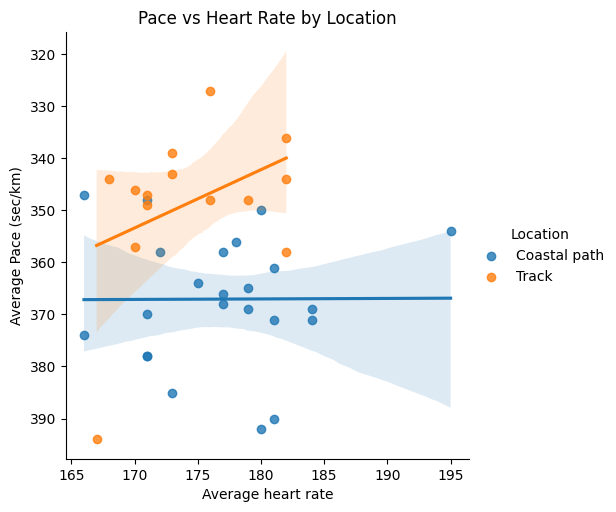

In [4]:
# we draw an lmplot to visualize the relationship
sns.lmplot(x="Avg HR", y="Pace_sec/km", hue="Location", data=runLoua_data)
plt.xlabel("Average heart rate")
plt.ylabel("Average Pace (sec/km)")
plt.title("Pace vs Heart Rate by Location")
plt.gca().invert_yaxis() 
plt.show()

## 2. Average Pace by Session Type and Surface

We now compare the pace depending on the session type (Intervals, Tempo, Threshold) and the surface (track/beach).


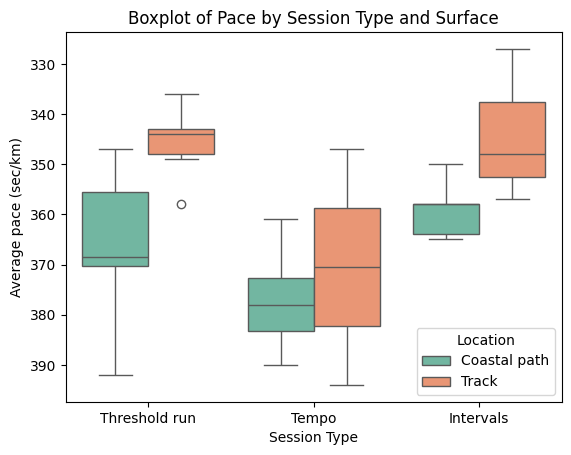

In [5]:
sns.boxplot(x="Type", y="Pace_sec/km", hue="Location",  data=runLoua_data, palette="Set2")
plt.gca().invert_yaxis()
plt.title("Boxplot of Pace by Session Type and Surface")
plt.xlabel("Session Type")
plt.ylabel("Average pace (sec/km)")
plt.show()

Even when comparing the same type of workout, the surface is still impactful.

## 3. Elevation Gain vs Pace

## Does elevation gain explain the pace difference between surfaces?

To help you visualize, the track I run on is 200 m long and nearly flat: the elevation changes are barely a meter, so there are no real slopes. We still get a good total of positive elevation gain because I run many laps, and it adds up. On the Coastal Path, there’s only the first small downhill; the rest of the route is flat, with no uphill towards the end.

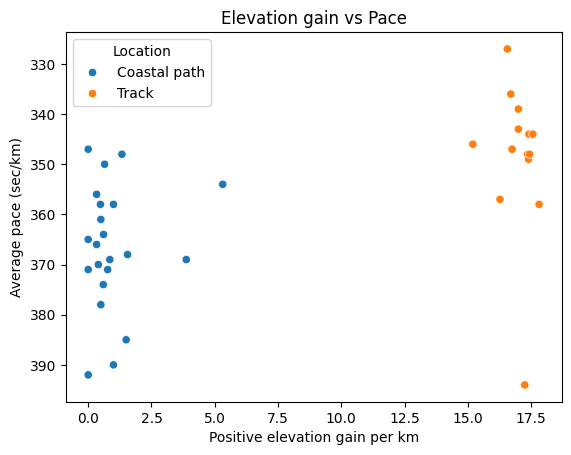

In [6]:
runLoua_data["pos_elev_gain/km"] = runLoua_data["Elev gain"] / runLoua_data["Distance"].replace(0, pd.NA)

sns.scatterplot(x="pos_elev_gain/km", y="Pace_sec/km", hue="Location", data=runLoua_data)
plt.gca().invert_yaxis()
plt.xlabel("Positive elevation gain per km")
plt.ylabel("Average pace (sec/km)")
plt.title("Elevation gain vs Pace")
plt.show()

Positive elevation gain usually slows down a run. Here, the values might suggest real slopes, but knowing the track well, I know these are just tiny bumps that accumulate over many laps, along with minor variations caused by watch noise. Yet, even these micro-slopes don’t slow me down compared to the Coastal Path, which has much lower positive elevation gain. The difference in speed therefore cannot be explained by elevation: despite a much higher cumulative gain on the track, i am clearly faster.

## 4. Monthly Evolution of Average Pace by Surface

Do I always run slower on the coastal path, or does it vary over time?

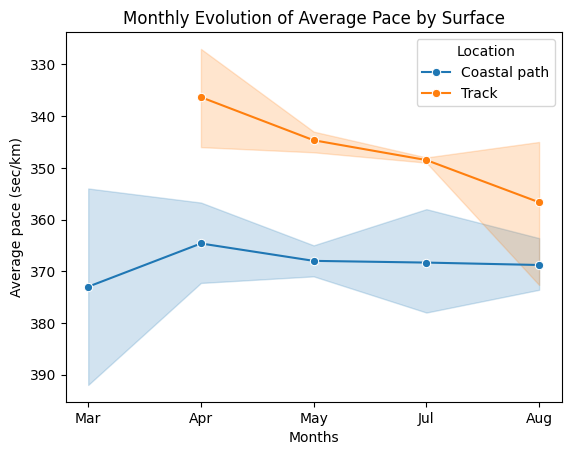

In [7]:
runLoua_data["Month"]=runLoua_data["Date"].dt.strftime("%b")

sns.lineplot(x="Month", y="Pace_sec/km", hue="Location", data=runLoua_data, marker="o")
plt.gca().invert_yaxis()
plt.xlabel("Months")
plt.ylabel("Average pace (sec/km)")
plt.title("Monthly Evolution of Average Pace by Surface")
plt.show()

5. Is the distance covered the same?

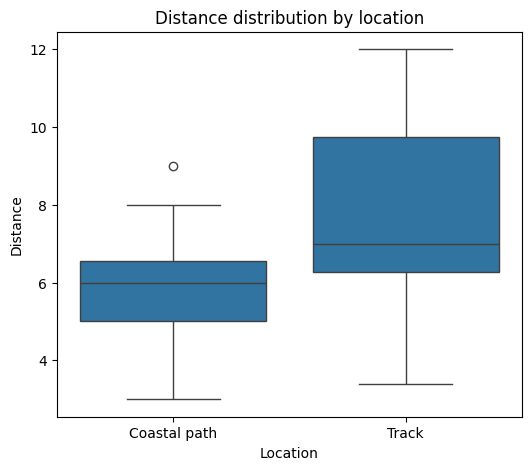

In [8]:
plt.figure(figsize=(6,5))
sns.boxplot(x="Location", y="Distance", data=runLoua_data)
plt.title("Distance distribution by location")
plt.show()

The distance covered on the track is generally higher, which in itself does not explain why I run faster on the track.

## Conclusion

Main takeaways:
-  For the same heart rate, pace is clearly faster on track than on beach.
-  The difference remains for each session type.
-  Elevation gain cannot explain the slower beach pace.
-  The surface impact is consistent across months.
-  The distance does not explain the pace difference.
## ANSWER HERE
I eventually realized that all these data points, which usually have a big impact on how a run unfolds, still can’t explain this big difference in pace that really matters to runners. It’s not the elevation, the distance, the heart effort, or even the type of workout. I thought about other factors, like temperature, but the difference remains during the same season. Then I figured it might be the course itself: on the track the route is more regular, without obstacles, the surface is uniform, and I don’t waste energy trying to stabilize my footing. In the end, these factors convinced me the most, because I can actually feel it when I run: going around in loops gives me confidence and puts me at ease.